In [1]:
import os 
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# Functions
def structure_file(df, test=False):
    if not test:
        df = df[0].str.split('\t', n=4, expand=True)
        df.columns = ["time", "sensor", "x", "y", "z"]
    else:
        df = df[0].str.split('\t', n=5, expand=True)
        df.columns = ["time", "sensor", "x", "y", "z", "labels"]
    
    GYR_data = df.loc[df['sensor'] == 'GYR']
    ACC_data = df.loc[df['sensor'] == 'ACC']

    GYR_data.index = GYR_data['time'].apply(pd.to_numeric)
    ACC_data.index = ACC_data['time'].apply(pd.to_numeric)
    GYR_data = GYR_data.drop('sensor', axis=1)
    ACC_data = ACC_data.drop('sensor', axis=1)
    if not test:
        GYR_data.columns = ['time_gyr', "gyr_x", "gyr_y", "gyr_z"]
        ACC_data.columns = ['time_acc', "acc_x", "acc_y", "acc_z"]
    else:
        GYR_data.columns = ['time_gyr', "gyr_x", "gyr_y", "gyr_z", "label"]
        ACC_data.columns = ['time_acc', "acc_x", "acc_y", "acc_z", "drop_label"]
        ACC_data = ACC_data.drop("drop_label", axis=1)
    min_idx = np.argmin([ACC_data.shape[0], GYR_data.shape[0]]) 
    max_idx = np.argmax([ACC_data.shape[0], GYR_data.shape[0]])  

    data_acc_gyr = [ACC_data, GYR_data] 
    data_acc_gyr[max_idx] = data_acc_gyr[max_idx].reindex(data_acc_gyr[min_idx].index, method='nearest', tolerance=0.02)
    new_set = pd.concat(data_acc_gyr, axis=1)
    pandas_data = new_set.dropna().reset_index(drop=True)
    pandas_data = pandas_data.apply(pd.to_numeric)
    return pandas_data

In [3]:
all_data = {'running':[],
           'walking':[],
           'standing_still':[]}


data_types = ["standing_still", "walking", "running"]
current_path = os.path.abspath('.')
for data_type in data_types:
    data_path = os.path.join(current_path, data_type)
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        data = pd.read_csv(file_path, header=None)
        pandas_data = structure_file(data)
        all_data[data_type].append(pandas_data)
        # pprint(pandas_data)


In [4]:
# Create data sets
from sklearn.model_selection import train_test_split
# create sequence of data
num_channels = 6
time_series_len = 200

num_samples = 0
for key in all_data:
    for data_sample in all_data[key]:
        nr_sample = 0
        while nr_sample < data_sample.shape[0]//time_series_len -1:
            nr_sample += 1
            num_samples += 1            

#data_np = np.zeros((num_samples, num_channels, time_series_len))
#label_np = np.zeros(num_samples)


data_list = []
label_list = []


key_to_label = {'running': np.array([1, 0, 0]),
                'walking':  np.array([0, 1, 0]),
                'standing_still':  np.array([0, 0, 1])}

channels = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
#channels = ['gyr_x', 'gyr_y', 'gyr_z']

nr_sample = 0
for key in all_data:
    nr_sub_sample = 0
    for data_sample in all_data[key]:
        start_v = 0
        while nr_sub_sample < data_sample.shape[0]//time_series_len - 1:
            label_list.append(key_to_label[key])
            data_sample_np = np.zeros((num_channels, time_series_len))
            for i in range(num_channels):
                data_key = channels[i]
                data_sample_np[i, :] = data_sample[data_key].iloc[start_v: start_v+time_series_len]
            data_list.append(data_sample_np.T)
            start_v += time_series_len
            nr_sub_sample += 1
            nr_sample += 1
            

x_train, x_test_val, y_train, y_test_val = train_test_split(data_list, label_list, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=42)

In [5]:
tensor_x_train = torch.Tensor(x_train)
tensor_y_train = torch.Tensor(y_train)

tensor_x_test = torch.Tensor(x_test)
tensor_y_test = torch.Tensor(y_test)

tensor_x_val = torch.Tensor(x_val)
tensor_y_val = torch.Tensor(y_val)

train_dataset = TensorDataset(tensor_x_train, tensor_y_train) 
test_dataset = TensorDataset(tensor_x_test, tensor_y_test) 
val_dataset = TensorDataset(tensor_x_val, tensor_y_val) 

train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=64)
val_data_loader = DataLoader(val_dataset, batch_size=64)


/tmp/ipykernel_25499/2617451969.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/torch/csrc/utils/tensor_new.cpp:201.)
  tensor_x_train = torch.Tensor(x_train)


# Model



In [6]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.kernel_size = 21

        # conv layer
        self.conv1 = nn.Conv1d(in_channels=6, 
                               out_channels=12, 
                               kernel_size=self.kernel_size, 
                               stride=1,
                               padding=self._padding(1),
                               bias=False)
        self.conv2 = nn.Conv1d(in_channels=12, 
                               out_channels=24, 
                               kernel_size=self.kernel_size, 
                               stride=1,
                               padding=self._padding(1),
                               bias=False)
        self.conv3 = nn.Conv1d(in_channels=24, 
                               out_channels=48, 
                               kernel_size=self.kernel_size, 
                               stride=2,
                               padding=self._padding(2),
                               bias=False)
        self.conv4 = nn.Conv1d(in_channels=48, 
                               out_channels=96, 
                               kernel_size=self.kernel_size, 
                               stride=2,
                               padding=self._padding(2),
                               bias=False)
        self.conv5 = nn.Conv1d(in_channels=96, 
                               out_channels=192, 
                               kernel_size=self.kernel_size, 
                               stride=2,
                               padding=self._padding(2),
                               bias=False)
        self.conv6 = nn.Conv1d(in_channels=192, 
                               out_channels=192, 
                               kernel_size=self.kernel_size, 
                               stride=2,
                               padding=self._padding(2),
                               bias=False)                                                         
        # linear layer
        self.lin1 = nn.LazyLinear(out_features=1024)     
        self.lin2 = nn.LazyLinear(out_features=256)
        self.lin3 = nn.LazyLinear(out_features=3)        

        # ReLU
        self.bn1 = nn.BatchNorm1d(12)
        self.bn2 = nn.BatchNorm1d(24)
        self.bn3 = nn.BatchNorm1d(48)
        self.bn4 = nn.BatchNorm1d(96)
        self.bn5 = nn.BatchNorm1d(192)        
        self.bn6 = nn.BatchNorm1d(192)   
        self.relu = nn.ReLU()
        self.d_small=nn.Dropout(p=0.25)
        self.d=nn.Dropout(p=0.5)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

    def forward(self, x):
        x= x.transpose(2,1)

        x = self.bn1(self.d_small(self.relu(self.conv1(x))))
        x = self.bn2(self.d_small(self.relu(self.conv2(x))))
        x = self.bn3(self.d_small(self.relu(self.conv3(x))))
        x = self.bn4(self.d_small(self.relu(self.conv4(x))))
        x = self.bn5(self.d_small(self.relu(self.conv5(x))))    
        x = self.bn6(self.d_small(self.relu(self.conv6(x))))
        x = x.view(x.size(0), -1)
        x = self.d(self.relu(self.lin1(x)))
        x = self.d(self.relu(self.lin2(x)))
        x = F.log_softmax(self.lin3(x), dim=1)
        return x          

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")


model = Model()
model.to(device);
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


/home/gabwal/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/gabwal/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
def evaluate_model(val_data_loader, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_data_loader:
            pred = model(b_x.to(device))
            loss = loss_fn(pred, b_y.to(device))
            losses.append(loss.item())
            hard_preds = pred.argmax(dim=1)
            n_correct += torch.sum(pred.argmax(dim=1) == b_y.argmax(dim=1).to(device)).item()
        val_accuracy = n_correct/len(val_data_loader.dataset)
        val_avg_loss = sum(losses)/len(losses)    
    
    return val_accuracy, val_avg_loss

In [9]:
def train_network(model, loss_fn, optimizer, num_epochs, train_data_loader, val_data_loader):

    val_loss_data = []
    train_loss_data = []

    val_acc_data = []
    train_acc_data = []

    for epoch in range(num_epochs):
        losses = []
        n_correct = 0
        for b_x, b_y in train_data_loader:

            # Compute predictions and losses
            pred = model(b_x.to(device))
            loss = loss_fn(pred, b_y.to(device))
            losses.append(loss.item())

            # Count number of correct predictions
            hard_preds = pred.argmax(dim=1)
            #print(pred.argmax(dim=1))
            n_correct += torch.sum(pred.argmax(dim=1) == b_y.argmax(dim=1).to(device)).item()

            # Backpropagate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_accuracy = n_correct/len(train_data_loader.dataset)
        train_avg_loss = sum(losses)/len(losses)    

        # Compute accuracy and loss in the entire validation set
        val_accuracy, val_avg_loss = evaluate_model(val_data_loader, model, loss_fn)

        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.4f} '
        display_str += '\tLoss (val): {:.4f}'
        display_str += '\tAccuracy: {:.4f} '
        display_str += '\tAccuracy (val): {:.4f}'
        print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

        val_loss_data.append(val_avg_loss)
        train_loss_data.append(train_avg_loss)

        val_acc_data.append(val_accuracy)
        train_acc_data.append(train_accuracy)

    
    torch.cuda.empty_cache()
    
    return val_loss_data, train_loss_data, val_acc_data, train_acc_data

val_loss_data, train_loss_data, val_acc_data, train_acc_data = train_network(model=model, 
                                                                             loss_fn=loss_fn,
                                                                             optimizer=optimizer, 
                                                                             num_epochs=15,
                                                                             train_data_loader=train_data_loader,
                                                                             val_data_loader=test_data_loader)



Epoch 0 	Loss: 0.5899 	Loss (val): 0.2719	Accuracy: 0.7169 	Accuracy (val): 0.9325
Epoch 1 	Loss: 0.1472 	Loss (val): 0.0463	Accuracy: 0.9616 	Accuracy (val): 0.9921
Epoch 2 	Loss: 0.0601 	Loss (val): 0.0991	Accuracy: 0.9894 	Accuracy (val): 0.9683
Epoch 3 	Loss: 0.0571 	Loss (val): 0.0361	Accuracy: 0.9854 	Accuracy (val): 0.9921
Epoch 4 	Loss: 0.0620 	Loss (val): 0.0662	Accuracy: 0.9907 	Accuracy (val): 0.9841
Epoch 5 	Loss: 0.0441 	Loss (val): 0.0429	Accuracy: 0.9907 	Accuracy (val): 0.9841
Epoch 6 	Loss: 0.0300 	Loss (val): 0.0274	Accuracy: 0.9894 	Accuracy (val): 0.9921
Epoch 7 	Loss: 0.0355 	Loss (val): 0.0480	Accuracy: 0.9894 	Accuracy (val): 0.9881
Epoch 8 	Loss: 0.0268 	Loss (val): 0.0245	Accuracy: 0.9921 	Accuracy (val): 0.9960
Epoch 9 	Loss: 0.0226 	Loss (val): 0.0252	Accuracy: 0.9934 	Accuracy (val): 0.9960
Epoch 10 	Loss: 0.0297 	Loss (val): 0.0401	Accuracy: 0.9894 	Accuracy (val): 0.9921
Epoch 11 	Loss: 0.0299 	Loss (val): 0.0484	Accuracy: 0.9907 	Accuracy (val): 0.9921
Ep

In [10]:
val_accuracy, val_avg_loss = evaluate_model(val_data_loader, model, loss_fn)
print('val_accuracy',val_accuracy)

val_accuracy 0.9920634920634921


In [11]:
torch.save(model, 'model')

# Test
Test on new seqience of data.


In [12]:
# Testing threshold

# ------------- stolen code from stackoverflow 
from collections import Counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]
# -----------------

file = "mixed_data_labeled.txt"
file_path = os.path.join(current_path, "test_data", file)
data = pd.read_csv(file_path, header=None)
pandas_data = structure_file(data, test=True)

data_list = []
label_list_torch = []
label_list = []

key_to_label = {'running': np.array([1, 0, 0]),
                'walking':  np.array([0, 1, 0]),
                'standing_still':  np.array([0, 0, 1])}

channels = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
#channels = ['gyr_x', 'gyr_y', 'gyr_z']

start_v = 0
nr_sample = 0
key_to_label = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]

while nr_sample < pandas_data.shape[0]//time_series_len - 1:
    local_label_list = pandas_data['label'].iloc[start_v: start_v+time_series_len]
    label_list.append(Most_Common(local_label_list))
    label_list_torch.append(key_to_label[Most_Common(local_label_list)])
    
    data_sample_np = np.zeros((num_channels, time_series_len))
    for i in range(num_channels):
        data_key = channels[i]
        data_sample_np[i, :] = pandas_data[data_key].iloc[start_v: start_v+time_series_len]
        
    data_list.append(data_sample_np.T)
    start_v += time_series_len
    nr_sub_sample += 1
    nr_sample += 1

tensor_x_val = torch.Tensor(data_list)
tensor_y_val = torch.Tensor(label_list_torch)

val_dataset = TensorDataset(tensor_x_val,tensor_y_val) 

val_data_loader_ = DataLoader(val_dataset, batch_size=1)

# predict

pred_list = []

with torch.no_grad():
    for b_x, b_y in val_data_loader_:
        pred = model(b_x.to(device))
        pred_list.append(np.argmax(pred.numpy()))
val_accuracy, val_avg_loss = evaluate_model(val_data_loader_, model, loss_fn)
print('val_accuracy',val_accuracy)

val_accuracy 0.2774451097804391


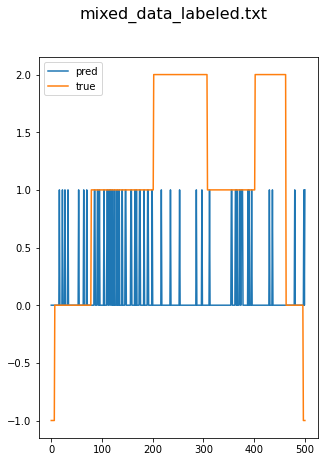

In [14]:
import matplotlib.pyplot as plt

# Plot data
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
fig.suptitle(file, fontsize=16)
ax.plot(pred_list, label='pred')
ax.plot(label_list, label='true')

plt.legend()
plt.show()